In [ ]:
%pip install --upgrade tensorflow==2.15.0

mengimport library yang dibutuhkan

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.17.1'

melakukan mounting google drive untuk menarik dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


mendeklarasikan path dataset, ukuran gambar, dan label

In [ ]:
PATH = '/content/drive/MyDrive/Computer Vision/dataset-coral-baru'
img_height = 224
img_width = 224
labels = ['Acropora Cervicornis', 'Alveopora', 'Caulastraea Furcata', 'Cyphastrea', 'Dendrogyra cylindrus', 'Diploria Strigosa', 'Discosoma', 'Euphyllia', 'Heliofungia actiniformis', 'Palythoa' ,'Ricordea']
print(labels)
print(len(labels))

['Acropora Cervicornis', 'Alveopora', 'Caulastraea Furcata', 'Cyphastrea', 'Dendrogyra cylindrus', 'Diploria Strigosa', 'Discosoma', 'Euphyllia', 'Heliofungia actiniformis', 'Palythoa', 'Ricordea']
11


mendeklarasikan jenis terumbu karang yang ilegal

In [ ]:
ilegal_coral = ['Acropora Cervicornis','Dendrogyra cylindrus','Diploria Strigosa','Euphyllia']

Meload Dataset dan mengaugmentasi menggunakan ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = .2,
    height_shift_range = .2,
    shear_range = .2,
    zoom_range = .2,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split = .2
)
train_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(img_height,img_width),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(img_height,img_width),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 980 images belonging to 11 classes.
Found 238 images belonging to 11 classes.


Membuat function untuk memanggil EfficientNetB6

In [ ]:
def feature_extractor_efficientNet(inputs):

  feature_extractor = tf.keras.applications.EfficientNetB6(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)

  x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor)
  return x

Membuat function untuk membuat classifier model

In [ ]:
def classifier(input):
    x = tf.keras.layers.BatchNormalization()(input)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(11, activation="softmax", name="classification")(x)
    return x

Membuat Function untuk membuat model secara keseluruhan

In [ ]:
def final_model(inputs):

    efficientNet_feature_extractor = feature_extractor_efficientNet(inputs)
    classification_output = classifier(efficientNet_feature_extractor)

    return classification_output

Membuat function untuk mendefinisikan dan compile model

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  return model

memanggil dan menampilkan struktur model

In [ ]:
model = define_compile_model()

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb6 (Functional)          │ (None, 7, 7, 2304)          │      40,960,143 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2304)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2304)                │           9,216 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,155,162 (160.81 MB)

 Trainable params: 41,926,115 (159.94 MB)

 Non-trainable params: 229,047 (894.72 KB)

mendeklarasikan callback yang dibutuhkan untuk melatih model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose = 1
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    min_lr=1e-6,
    patience=2,
    verbose=1
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Computer Vision/coral_classification_checkpoint_EfficientNetB6-528x528.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

Melatih model

In [ ]:
EPOCHS = 100
history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=train_generator.samples//64,validation_data = val_generator, validation_steps=val_generator.samples//64,callbacks=[early_stopping,lr_scheduler,checkpoint])

meload model yang sudah terlatih dari checkpoint yang disimpan di google drive

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Computer Vision/coral_classification_checkpoint_EfficientNetB6-224x224.h5')

melakukan testing pada model yang sudah terlatih

In [ ]:
# test the val generator without random
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_test = val_generator.classes

4/4 [==============================] - 11s 2s/step


menampilkan classification report yang berisikan precision, recall dan f1-score dari setiap kelas

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

0.9159663865546218
                          precision    recall  f1-score   support

    Acropora Cervicornis       0.96      1.00      0.98        24
               Alveopora       0.90      0.95      0.93        20
     Caulastraea Furcata       0.96      0.96      0.96        25
              Cyphastrea       0.90      1.00      0.95        19
    Dendrogyra cylindrus       0.94      0.94      0.94        17
       Diploria Strigosa       1.00      0.97      0.98        30
               Discosoma       0.90      0.75      0.82        24
               Euphyllia       0.83      0.87      0.85        23
Heliofungia actiniformis       0.89      0.81      0.85        21
                Palythoa       1.00      1.00      1.00        10
                Ricordea       0.81      0.88      0.85        25

                accuracy                           0.92       238
               macro avg       0.92      0.92      0.92       238
            weighted avg       0.92      0.92      0.92

menampilkan confusion matrix

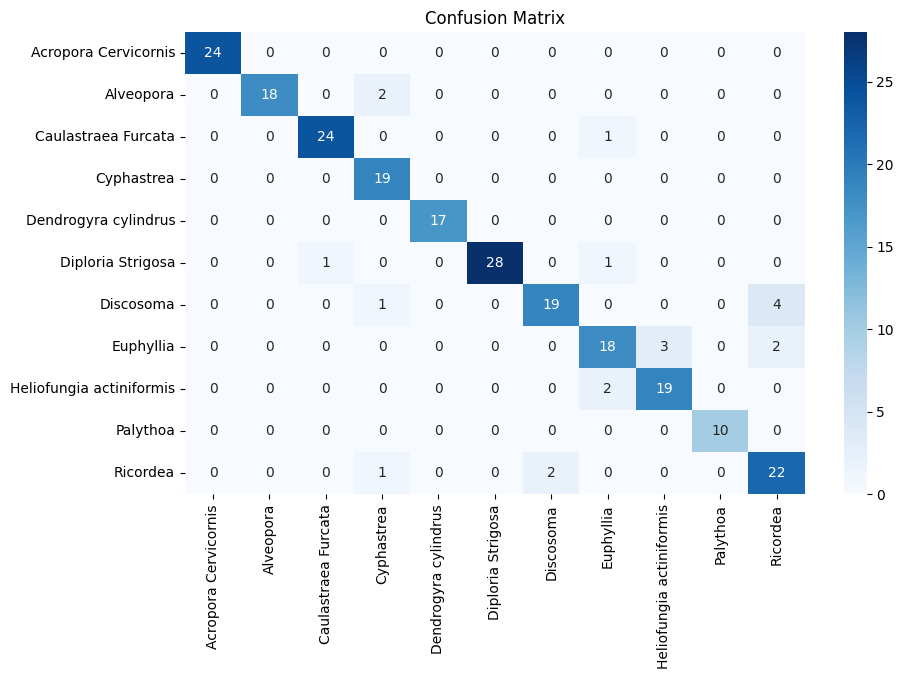

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.show()